# Figure 4.
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/22/2025          |
| Updated |  08/22/2025          |

Meridional profiles at $r = R_0 = 17.0\mathrm{\,au}$ (cf. Figure 3).
The upper horizontal axis converts latitudes along the bottom to $Z(R_0) = R_0\cos\theta$ in scale heights $H_0$ at $R_0$ (Section 3.1).
Referring to the left vertical axis, the solid blue curve shows the density $\rho$ in the thin-disk limit [equation (17)] and the dashed orange the Athena++ output [equation (15)] with floor $\rho_\mathrm{min} = 4.28\times10^{-26}\mathrm{\,g\,cm}^{-3}$.
Referring to the right axis, the solid green curve shows the effective optical depth to stellar irradiation $\tau_*$ [equation (19)] as outputted by the code.

rho_min = 4.28e-26 g/cm^3


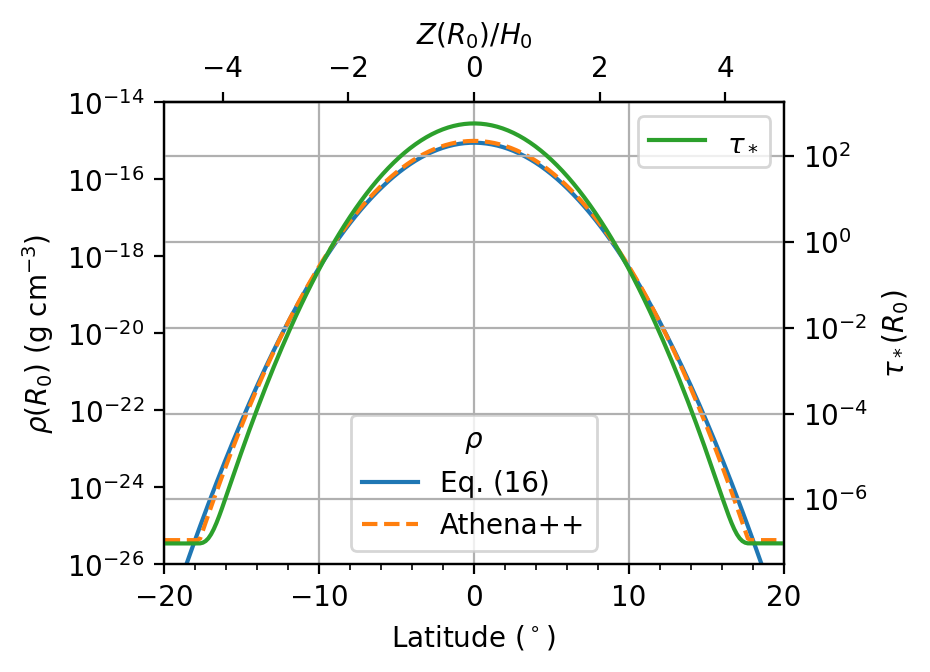

In [1]:
#===============================================================================
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# Theory
def rho_sig(rho_0, r0, p, r, theta):
    """ Eq. (19) """
    return rho_0*((r*np.sin(theta) + r0)/r0)**p\
        /(1 + np.exp(-np.exp(np.e)*(r*np.sin(theta) - r0)/r0))

def rho(rho_0, r0, p, r, theta, H):
    """ Eq. (16) """
    return rho_sig(rho_0, r0, p, r, theta)*np.exp(-(r*np.cos(theta)**2/2/H**2))

def lat2z(lat):
    """ Convert meridional latitude to cylindrical Z/H """
    theta = (90 - lat)*np.pi/180
    return r0*np.cos(theta)/h0

# Read and plot
fig, ax = plt.subplots(figsize=(4, 3), dpi=200)
ax_tau = ax.twinx()
problem_id = 'dsharp'
root = '../athena/models/dsharp_abs-sca'
path = f'{root}/nfreq/64'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
dfloor = athinput['hydro']['dfloor']
density_unit = athinput['radiation']['density_unit']
r0 = athinput['problem']['r0']
rho_0 = athinput['problem']['rho0']
h0 = np.sqrt(athinput['problem']['p0_over_r0'])*r0
p = athinput['problem']['dslope']
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
latitudes = 90 - athdf['x2v']*180/np.pi
x1_0 = np.searchsorted(athdf['x1f'], athinput['problem']['r0'])

# Diagnostics
print(f'rho_min = {dfloor*density_unit:.2e} g/cm^3')

# Density
ax.plot(latitudes, rho(rho_0, r0, p, r0, athdf['x2v'], h0)*density_unit,
        label='Eq. (16)')
ax.plot(latitudes, athdf['rho'][0,:,x1_0]*density_unit, ls='dashed',
        label='Athena++')

# Optical depth
f_star = 54
try:
    dtau = (athdf[f'Sigma_a_{f_star}'][0] + athdf[f'Sigma_s_{f_star}'][0])\
            *np.diff(athdf['x1f'])
except KeyError:
    dtau = athdf['Sigma_a_0'][0]*np.diff(athdf['x1f'])
tau_field = np.cumsum(dtau, axis=1)
ax_tau.plot(latitudes, tau_field[:,x1_0], color='tab:green', label=r'$\tau_*$')

# Format plots
ax.grid(axis='x')
ax.legend(title=r'$\rho$')
ax.minorticks_on()
ax.tick_params(axis='both', which='both')
ax.set(xlim=(-20, 20), ylim=(1e-26, 1e-14), xlabel=r'Latitude ($^\circ$)', 
       yscale='log', ylabel=r'$\rho(R_0)$ (g cm$^{-3}$)')
ax_tau.grid()
ax_tau.legend(loc='upper right')
ax_tau.set(yscale='log', ylabel=r'$\tau_*(R_0)$')
ax_tau.tick_params(axis='both', which='both')
secax = ax.secondary_xaxis('top', functions=(lat2z, lat2z))
secax.set(xlabel=r'$Z(R_0)/H_0$')
plt.savefig('figs/vertical.pdf', bbox_inches='tight', pad_inches=0.01)
#===============================================================================